In [69]:
import random
from scipy.stats import hypergeom
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [80]:
go_index_file=r'human_ensembl/human_ensembl_index.txt'
go_names_file=r'human_ensembl/human_ensembl_names.txt'
expression_file='PAGE-master/TEST/bladder.exp'

It is just an ensemble to ncbi translation function.

In [71]:
ens_ncbi={}
with open('bioDBnet_db2db_190531124545_1407326651.txt') as f:
        for line in f:
            ncbi=line.split()[0]
            for ens in line.split()[1:]:
                if ';' in ens:
                    ens=ens[:-1]
                ens_ncbi[ens]=ncbi
def ensemble_to_ncbi(di,ens_ncbi):
    for el in sorted(di):
        ncbi=[]
        for ens in di[el]:
            
            try:
                ncbi.append(ens_ncbi[ens])
            except:
                pass
        di[el]=ncbi

Functions which create profiles.

In [72]:
def get_expression_level(expression_file):
    expression_level=[]
    i=0
    with open(expression_file) as f:
        for line in f:
            if i!=0:
                li=line.split()
                expression_level.append((li[0],float(li[1])))
            i+=1
    return expression_level
def get_discrete_profile(v,nbins):
    bin_size=len(v)//nbins
    unique=sorted(set(v))
    bins=[]
    cat=0
    value_score={}
    filling=0
    for i in unique:
        filling+=v.count(i)
        value_score[i]=str(cat)
        if filling>=bin_size and cat<nbins-1:
            filling=0
            cat+=1
    return [int(i) for i in [value_score[i] for i in v]]
def get_eprofile(expression_level,nbins):
    expression_level_sorted=sorted(expression_level,key=lambda x : x[1])
    genes=[pair[0] for pair in expression_level_sorted]
    expression=[pair[1] for pair in expression_level_sorted]
    profile=get_discrete_profile(expression,nbins)
    return genes,profile
def get_go_names(go_names_file):
    go_names={}
    go_functions={}
    with open(go_names_file) as f:
        for line in f:
            name=line.split()[0]
            go_names[name]=[]
            go_functions[name]=' '.join(line.split()[1:-1])+'; '+name
    return go_names,go_functions
def get_go_indexes(go_index_file,go_names):
    with open(go_index_file) as f:
        for line in f:
            li=line.split()
            for el in li[1:]:
                go_names[el].append(li[0])
def get_go_profiles(go_names,genes):
    profiles={}
    for name in sorted(go_names):
        v=[]
        for gene in genes:
            if gene in go_names[name]:
                v.append(1)
            else:
                v.append(0)
        profiles[name]=v
    return profiles

This one is a function which computes hypergeometric p-value for each bin. At this stage I wonder what is the proper way to color heatmap? There are two kinds of hypergeometric p-values: cases of over and under expression. The article states that both of them are quantified. And:"If pover<punder, we consider the pathway to be over-represented in the expression bin/cluster; otherwise, it is under-represented." 
I am still missing the point which of these p is used eventually.

In [73]:
def get_p_values(go_profile,nbins):
    bin_size=len(go_profile)//nbins
    remain=len(go_profile)-nbins*bin_size
    #remain=0
    p_values=[]
    objects_total=sum(go_profile)
    total_size=len(go_profile)
    objects_in_bin=sum(go_profile[bin_size+remain:bin_size])
    p=hypergeometric(objects_in_bin ,total_size, objects_total, bin_size)
    p_values.append(p)
    for i in range(1,nbins):
        objects_in_bin=sum(go_profile[bin_size*i:bin_size*(i+1)])
        p=hypergeometric(objects_in_bin ,total_size, objects_total, bin_size)
        p_values.append(p)
    return p_values

In [74]:
def draw_heatmap(p_values):
    p_names=p_values.keys()
    p_values = np.array([p_values[name] for name in p_values])
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(0))
    ax.set_yticks(np.arange(len(p_names)))
    ax.set_yticklabels(p_names)
    plt.tick_params(axis='y', which='both', labelleft=False, labelright=True,length=0)
    #ax.tick_params(direction='out')
    plt.set_cmap('RdBu_r')
    #ax.set_title('')
    im = ax.imshow(p_values)
    #fig.tight_layout()
    cbaxes = fig.add_axes([-0.1, 0.25, 0.03, 0.5])  # This is the position for the colorbar
    hm=plt.colorbar(im,cax = cbaxes)
    #ax.set_xlzabel('Expression increases –>')
    #plt.savefig('heatmap.png')
    plt.show()
    plt.close()

Function calculates conditional information. X is expression profile, Y is GO profile, Z is a vector which represents the abundance of each gene.
Please, check if I am getting the idea of CMI correctly. 
I (X; Y |Z) = Ep(x,y,z)*log p(X, Y |Z) / p(X|Z) p(Y |Z)
so it should be by probability property
= Ep(x,y,z)*log (p(X, Y, Z)/p(Z)) / (p(X,Z)/p(Z) * p(Y, Z)/p(Z))

=Ep(x,y,z)*log (p(X, Y, Z)* p(Z)) / (p(X,Z) * p(Y, Z))

In [ ]:
def marginal_entropy(v):
    unique=list(set(v))
    entropy=0
    for el in unique:
        p=v.count(el)/len(v)
        entropy+=p*math.log(p,2)
    return - entropy
def joint_entropy(v1,v2):
    pairs=list(zip(v1,v2))
    unique_pairs=list(set(pairs))
    entropy=0
    for el in unique_pairs:
        p=pairs.count(el)/len(pairs)
        entropy+=p*math.log(p,2)
    return -entropy
def mutual_information(v1,v2):
    return marginal_entropy(v1)+marginal_entropy(v2)-joint_entropy(v1,v2)

In [368]:
def cmi_formula(x_z_freq,y_z_freq,x_y_z_freq,z_prob,l):
    cmi=0
    x_z_prob={key:x_z_freq[key]/l for key in x_z_freq}
    y_z_prob={key:y_z_freq[key]/l for key in y_z_freq}
    x_y_z_prob={key:x_y_z_freq[key]/l for key in x_y_z_freq}
    for combination in x_y_z_prob:
        x_y_z_probability=x_y_z_prob[combination]
        x_z_probability=x_z_prob[(combination[0],combination[2])]
        y_z_probability=y_z_prob[(combination[1],combination[2])]
        z_probability=z_prob[combination[2]]
        if x_z_probability!=0 and y_z_probability!=0 and x_y_z_probability!=0:
            cmi+=x_y_z_probability*math.log(x_y_z_probability*z_probability/
                                              x_z_probability / 
                                              y_z_probability , 2)
    return cmi

def conditional_mutual_information(x,y,z,stat_tests=False,accepted_pathways_profile=None,r=5,shuffles=1000,max_p=0.005):
    #start
    l=len(x)
    if accepted_pathways_profile ==None:
        accepted_pathways_profile=[0]*l
    z_prob={i:z.count(i)/len(z) for i in set(z)}
    x_z_freq={(a,b):0 for a in set(x) for b in set(z)}
    y_z_freq={(a,b):0 for a in set(y) for b in set(z)}
    x_y_z_freq={(a,b,c):0 for a in set(x) for b in set(y) for c in set(z)}
    for pair in zip(x,z):
        x_z_freq[pair]+=1
    for pair in zip(y,z):
        y_z_freq[pair]+=1
    for pair in zip(x,y,z):
        x_y_z_freq[pair]+=1
    
    cmi=cmi_formula(x_z_freq,y_z_freq,x_y_z_freq,z_prob,l)
    
    if stat_tests:
        
        #Removing redundantly informative pathways
        try:
            if conditional_mutual_information(y,x,accepted_pathways_profile)/mutual_information(y,accepted_pathways_profile)<r:
                return 0
        except:
            pass
        
        #Randomization-based statistical testing
        
        x_old=x
        x_new=x[:]
        j=0
        max_j=shuffles*max_p
        for i in range(shuffles):
            random.shuffle(x_new)
            for i in range(l):
                if x_old[i]!=x_new[i]:
                    x_z_freq[(x_old[i],z[i])]-=1
                    x_z_freq[(x_new[i],z[i])]+=1
                    x_y_z_freq[(x_old[i],y[i],z[i])]-=1
                    x_y_z_freq[(x_new[i],y[i],z[i])]+=1
            new_cmi=cmi_formula(x_z_freq,y_z_freq,x_y_z_freq,z_prob,l)
            if new_cmi>cmi:
                j+=1
            if j>max_j:
                return 0
            x_old=x_new[:]
        return cmi
    else:
        return cmi
    
#515 ms ± 9.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [370]:
print(conditional_mutual_information(li,go_profiles['GO:0042254'],abundance_profile,stat_tests=1))
print(conditional_mutual_information(eprofile,go_profiles['GO:0042254'],abundance_profile))

0
0.01791246094582573


In [345]:
#tried to split bins differently
l=len(eprofile)
binsize=int(l/100)
remain=l-binsize*100
li=[]
for n in range(100):
    li+=[n]*binsize
li+=[n]*remain

Here the programm is initialized

In [321]:
abundance_nbins=100
expression_nbins=100
draw_nbins=15
expression_level=get_expression_level(expression_file)
genes, eprofile=get_eprofile(expression_level,expression_nbins)
go_names, go_functions=get_go_names(go_names_file)
get_go_indexes(go_index_file,go_names)
ensemble_to_ncbi(go_names,ens_ncbi)
go_profiles=get_go_profiles(go_names,genes)
abundance_profile=list(np.sum([go_profiles[name] for name in go_profiles],axis=0))
abundance_profile=get_discrete_profile(abundance_profile,abundance_nbins)
cmi_dic={}
accepted_pathways_profile=[0]*len(eprofile)

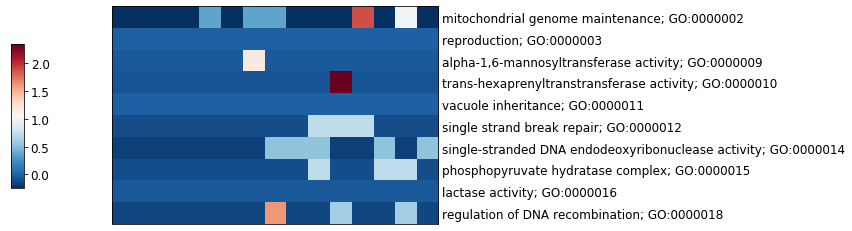

In [356]:
i=10 #take only first n profiles while testing
for name in go_profiles:
    cmi= conditional_mutual_information(eprofile,go_profiles[name],abundance_profile,accepted_pathways_profile=accepted_pathways_profile,stat_tests=True)
    cmi_dic[name]=cmi
    if cmi:
        accepted_pathways_profile=map(sum, zip(accepted_pathways_profile,go_profiles[name]))
    i-=1
    if i<0:
        break
top_cmi=sorted(cmi_dic.items(),key=lambda x: -x[1])[:10]
p_values={}
for item in top_cmi:
    p_values[go_functions[item[0]]]=get_p_values(go_profiles[item[0]],draw_nbins)
draw_heatmap(p_values)

Article:
https://tavazoielab.c2b2.columbia.edu/lab/publications/Goodarzi_etal_Mol_Cell_12_11_2009.pdf
Supplementary:
https://www.cell.com/cms/10.1016/j.molcel.2009.11.016/attachment/9ade54f4-6476-4ee1-ac73-70f10352c31d/mmc1.pdf

Below there is some technical/testing stuff. Needless to pay any attention.

In [ ]:
def factorial(a):
    if a==0:
        return 1
    else:
        return a*factorial(a-1)
def C(n,k):
    try:
        return factorial(n)/(factorial(k)*factorial(n-k))
    except:
        return 0

def hypergeometric(objects_in_bin ,total_size, objects_total, bin_size):
    '''p_over=0
    p_under=0
    for i in range(objects_in_bin):
        p_under+=C(objects_total,i)*C(total_size-objects_total,bin_size-i)/C(total_size,bin_size)
    for i in range(objects_in_bin,total_size):
        p_over+=C(objects_total,i)*C(total_size-objects_total,bin_size-i)/C(total_size,bin_size)'''
    p_over=math.log(hypergeom.sf(objects_in_bin-1 ,total_size, objects_total, bin_size),10)
    p_under=math.log(hypergeom.cdf(objects_in_bin,total_size, objects_total, bin_size),10)
    p_=math.log(hypergeom.pmf(objects_in_bin,total_size, objects_total, bin_size),10)
    if p_over<p_under:
        p=-p_over
    else:
        p=p_under
    if abs(p)>3:
        return p/(abs(p))*3
    else:
        return p
        
#p_over is equivalent to hypergeom.cdf
#p_under is equivalent to hypergeom.sf 

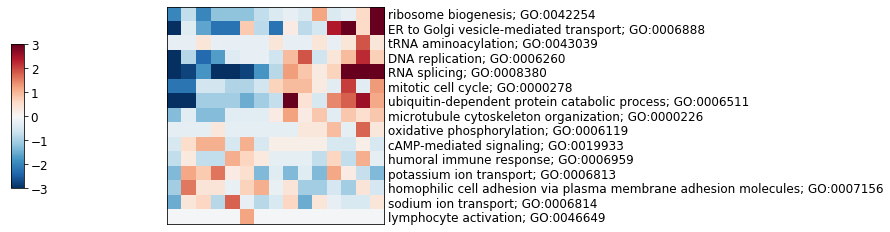

In [457]:
#Here I test drawing heatmaps
p_vaalues={}
GOs=['GO:0042254','GO:0006888','GO:0043039','GO:0006260','GO:0008380','GO:0000278','GO:0006511','GO:0000226','GO:0006119'
   ,'GO:0019933','GO:0006959','GO:0006813','GO:0007156','GO:0006814','GO:0046649']
for GO in GOs:
    p_vaalues[go_functions[GO]]=get_p_values(go_profiles[GO],15)
draw_heatmap(p_vaalues)

In [467]:
#refseq_to_entrez more than 2000 refseq ids from Hani's test are missing
'''with open('gene_result.txt') as f:
    genes={}
    for line in f:
        li=line.split('\t')
        if li[11]
        genes[li[11]]=[li[2],li[5]]
refseq_entrez={}
with open('hgnc_complete_set.txt') as f:
    names=f.readline().split()
    print(list(zip(names,list(range(len(names))))))
    for line in f:
        li=line.split('\t')
        if len(li)==51:
            if li[23]!='' and li[18]!='':
                refseq_entrez[li[23]]=li[18]'''

In [ ]:
#alternative conditional_mutual_information
"""def conditional_mutual_information(x,y,z):
    cmi=0
    V=list(zip(x,y,z))
    V_prob={i:V.count(i)/len(V) for i in set(V)}
    x_z=list(zip(x,z))
    x_z_prob={i:x_z.count(i)/len(x_z) for i in set(x_z)}
    y_z=list(zip(y,z))
    y_z_prob={i:y_z.count(i)/len(y_z) for i in set(y_z)}
    z_prob={i:z.count(i)/len(z) for i in set(z)}
    for combination in V:
        cmi+=V_prob[combination]*math.log(V_prob[combination]*z_prob[combination[2]]/
                                          x_z_prob[(combination[0],combination[2])] / 
                                          y_z_prob[(combination[1],combination[2])],2)
    return cmi
def cmi_and_test(eprofile,go_profile,abundance_profile,accepted_pathways_profile,r=5,shuffles=10000,max_p=0.05):
    cmi=conditional_mutual_information(eprofile,go_profile,abundance_profile)
    go_profile=go_profile[:]

    #Removing redundantly informative pathways
    try:
        if conditional_mutual_information(go_profile,eprofile,accepted_pathways_profile)/mutual_information(go_profile,accepted_pathways_profile)<r:
            return 0
    except:
        pass
    
    #Randomization-based statistical testing
    j=0
    max_j=shuffles*max_p
    for i in range(shuffles):
        random.shuffle(go_profile)
        if conditional_mutual_information(eprofile,go_profile,abundance_profile)>cmi:
            j+=1
        if j>max_j:
            return 0

    return cmi"""
#1min 3s ± 1.41 s per loop (mean ± std. dev. of 7 runs, 1 loop each)